# Introduction

Before diving into the details of the problem, let's understand what is the goal?

```
1. We need to predict the short-term volatility (for 10 minutes range) for hundreds of stocks across different sectors. 
2. We have hundreds of millions of highly granular(i.e. detailed) data. 
3. For the first three months, the forecasting model will be over given dataset for 10 minute periods. For next three months, it will predicted on real time data. (Just like Jane street Market Prediction competition).
4. Evaluation Metrics: RMSPE (Root Mean Square Percentage Error).
5. This is a code competition and expect to predict 150K target values in RUN TIME.
6. Public and Private test data will have zero over lap. Hence, just build a generalized model/models. Forget about the leaderboard during training phase :)
```

# Dataset Overview

- Given `Order Book` snapshots and `Executed Trades` in parquet format.
- What are Order books and Executed Trades, refer to the notebook by organizers to get domain expertise.

# Domain Introduction and Resources

- Volatility: https://www.optiver.com/insights/guides/options-volatility/
- How Price is related to Volatility?: https://www.optiver.com/insights/guides/options-pricing/
- Organizer's Notebook on Introduction and Domain Knowledge: https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data

In [1]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold

import xgboost as xgb

tqdm.pandas()
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [2]:
# in order to preprocess parquet files, use the standard pyarrow lib
!pip install pyarrow

import pyarrow.parquet as pq

In [3]:
# files
train = pd.read_csv("../input/optiver-realized-volatility-prediction/train.csv")
test = pd.read_csv("../input/optiver-realized-volatility-prediction/test.csv")
ss = pd.read_csv("../input/optiver-realized-volatility-prediction/sample_submission.csv")

print("Train Info: \n")
train.info()

print("\nTest Info: \n")
test.info()

print("\nSample Submission Format: \n")
ss.info()

Train Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428932 entries, 0 to 428931
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   stock_id  428932 non-null  int64  
 1   time_id   428932 non-null  int64  
 2   target    428932 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 9.8 MB

Test Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   stock_id  3 non-null      int64 
 1   time_id   3 non-null      int64 
 2   row_id    3 non-null      object
dtypes: int64(2), object(1)
memory usage: 200.0+ bytes

Sample Submission Format: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   row_id  3 non-null      object 
 1   target  3 non-null    

# Data Attributes

- Train
    - stock_id: ID code for the stock. (as categorical in parquet files, can be converted into int8 dtype)
    - time_id : ID code for time bucket. Not necessarily sequential. Consistent across all stocks.
    - target  : The realized volatility computed over a `10 minute` window. For each stock-id-time_id pair, we have a target.
    

- Test
    - stock_id: same as above
    - time_id : same as above
    - row_id  : Unique identifier for the submission row. One row for each stock-time pair.


- Sample Submission
    - row_id  : same as above
    - target  : same as above

In [4]:
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [5]:
train["stock_id"].value_counts()

0      3830
81     3830
94     3830
93     3830
90     3830
       ... 
13     3829
75     3829
100    3829
80     3820
38     3815
Name: stock_id, Length: 112, dtype: int64

So, for each stock ID, we have 3830/3829 time IDs, except stock 80, and stock 38, having 3820 and 3815 time IDs respectively. And we have total `112` stocks. Meta data for each stock are available in corresponding `book` and `trade` folders. We will look into each stock later, let's have a look on the time id, target distributions w.r.t. stock id.

In [6]:
train["time_id"].value_counts()

8196     112
25504    112
8623     112
17315    112
15276    112
        ... 
6172     111
32186    111
10765    111
27795    111
29802    111
Name: time_id, Length: 3830, dtype: int64

As mentioned, yeah the time IDs are consistent throughout the stocks. P.S: There are 3830 time IDs. Let's pick a particular stock and have a brief overview of what we have.

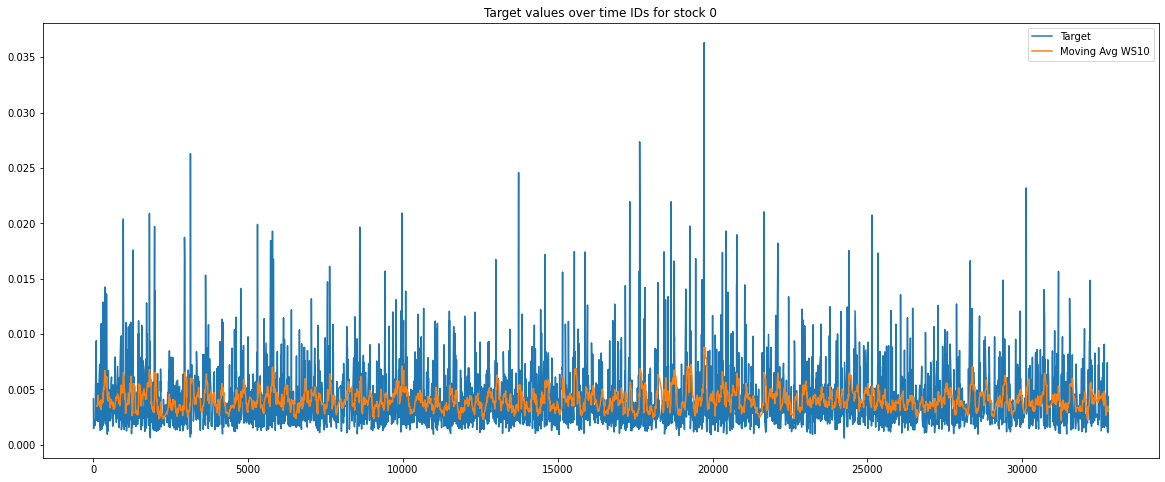

In [7]:
stock_example = train[train["stock_id"]==0]

plt.figure(figsize=(20, 8))
plt.plot(stock_example["time_id"].values, stock_example["target"].values, label="Target")
plt.plot(stock_example["time_id"].values, stock_example["target"].rolling(window=10).mean().values, label="Moving Avg WS10") #WS=Window Size
plt.title("Target values over time IDs for stock 0")
plt.legend()
plt.show()

count    428932.000000
mean          0.003880
std           0.002936
min           0.000105
25%           0.002026
50%           0.003048
75%           0.004738
max           0.070321
Name: target, dtype: float64

  0%|          | 0/428932 [00:00<?, ?it/s]

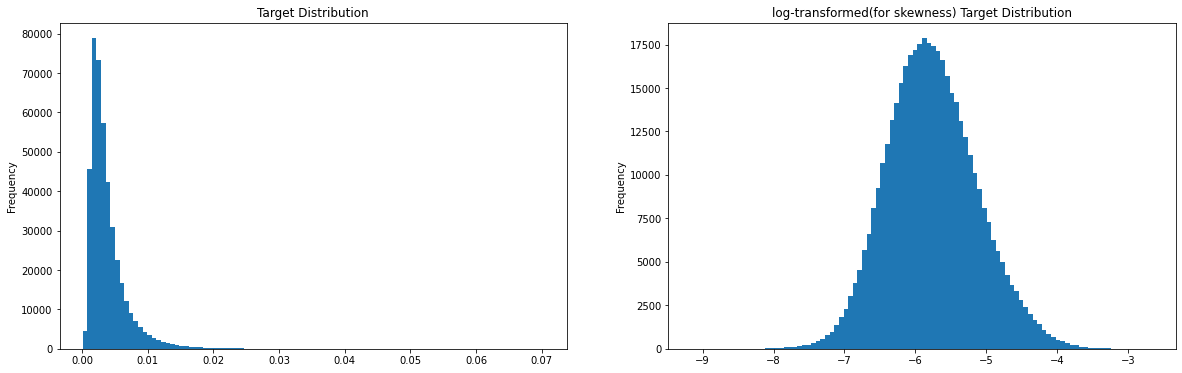

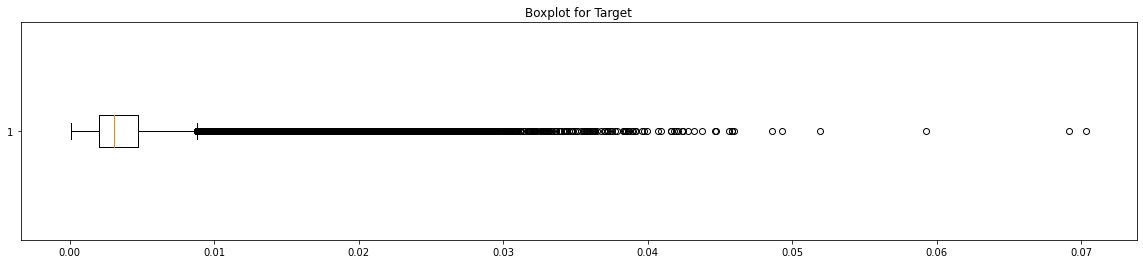

In [8]:
display(train["target"].describe())

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
train["target"].plot(kind="hist", bins=100, ax=axs[0], title="Target Distribution")
train["target"].progress_apply(np.log).plot(kind="hist", bins=100, ax=axs[1], title="log-transformed(for skewness) Target Distribution")

plt.figure(figsize=(20, 4))
plt.boxplot(train["target"], vert=False)
plt.title("Boxplot for Target")
plt.show()

In [9]:
def book_length(stock_id):
    return len(pq.read_table(f"../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id={stock_id}"))
    pass

def trade_length(stock_id):
    return len(pq.read_table(f"../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id={stock_id}"))
    pass

train_meta = pd.DataFrame(columns=["stock_id", "len_order_book", "len_trade"])
train_meta["stock_id"] = train["stock_id"].unique()
train_meta["len_order_book"] = train_meta["stock_id"].progress_apply(book_length)
train_meta["len_trade"] = train_meta["stock_id"].progress_apply(trade_length)

train_meta

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

,stock_id,len_order_book,len_trade
0,0,917553,123443
1,1,1507532,296210
2,2,1903140,434621
3,3,1269461,279290
4,4,1073989,139461
...,...,...,...
107,122,1543033,261662
108,123,2071321,587486
109,124,2269682,1147985
110,125,1891264,360899


# Meta Data Overview

Let's investigate parquet files for a single stock for Order book and trades.

In [10]:
# reading book sample
print("A book sample: \n")
book_sample = pq.read_table("../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0")
book_sample = book_sample.to_pandas()
display(book_sample)

# reading trade sample
print("\nA trade sample: \n")
trade_sample = pq.read_table("../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0")
trade_sample = trade_sample.to_pandas()
display(trade_sample)

A book sample: 



,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28



A trade sample: 



,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
...,...,...,...,...,...
123438,32767,471,0.998659,200,3
123439,32767,517,0.998515,90,1
123440,32767,523,0.998563,1,1
123441,32767,542,0.998803,90,4


## Notes:

- Our data points are (X_i, Y_i), where X_i is the feature vector for every (stock_id, time_id) pair, and Y_i is the corresponding target.
- Y_i can be calculated from squared aggregation of log of WAP(weighted avg price), (Ref: Organizer's notebook.)
- If we create a cleaned, and one merged dataset, we can have below features (as of now, pure naive features) for every (X, Y):
    - Statistical data about `seconds_in_bucket`.
    - `wap` calculated from most and second most competitive buy/sell.
    - `log(wap)`, and probably the calculated squared aggregrate of log(wap) from the log return. Don't know whether we should use this as a feature in our model training, as it is most likely to have a high, very high correlation with the `target` value. Let's see, no sepculations now.
    - Aggregrate statistical values, and some feature engineering between pirces and sizes.

Speakng of `time_id`, let's see the occurances we have for a given time id per stock.

In [11]:
# for book sample
print("For order book: \n", book_sample["time_id"].value_counts())
# for trade sample
print("For trade sample: \n", trade_sample["time_id"].value_counts())

For order book: 
 14243    549
32342    538
26874    523
4004     505
4560     505
        ... 
23153     85
17506     85
9936      84
29577     80
13484     73
Name: time_id, Length: 3830, dtype: int64
For trade sample: 
 19999    119
28839    117
6931     117
4004     108
32466    106
        ... 
15038      4
32033      3
5658       2
9936       2
640        2
Name: time_id, Length: 3830, dtype: int64


We observed that, we have around ~3830 instances for a given `(stock_id, time_id)` pair, and for each pair we can have a seuqential data/array of WAP. The length may vary from 70-550 (it's for stock 0, results can be different for different stock ids). If we are to treat these as a sequential data, the length will be a matter of concern. Well, will dive into that later. 

Before diving into details, let's look into a single data point, i.e. one (stock_id, time_id) pair. Let's take `time_id=5` for `stock_id=0`.

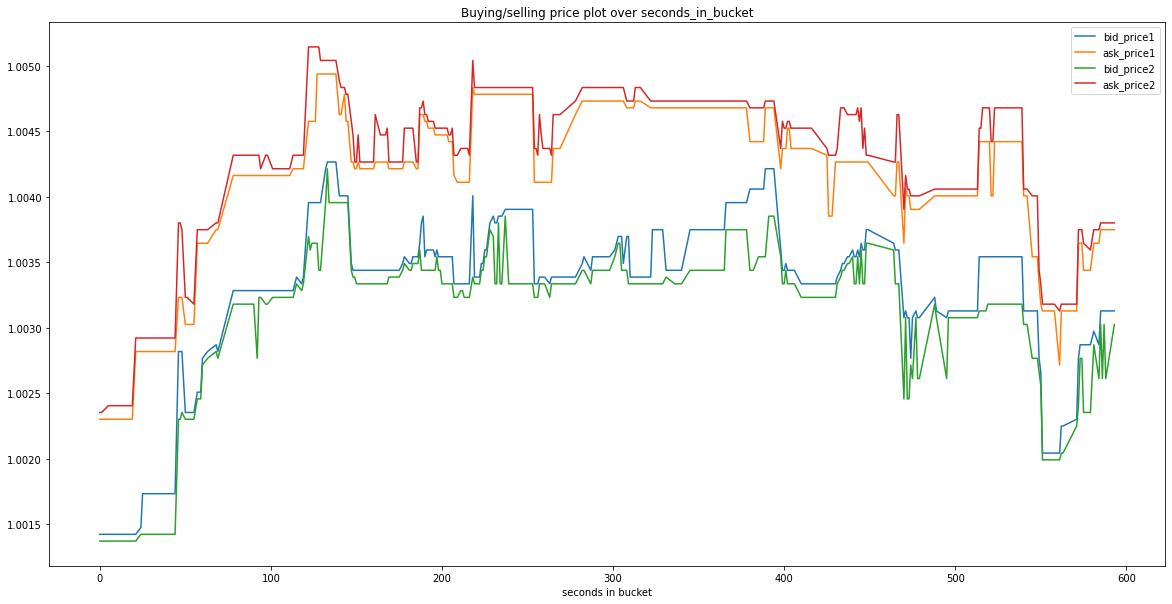

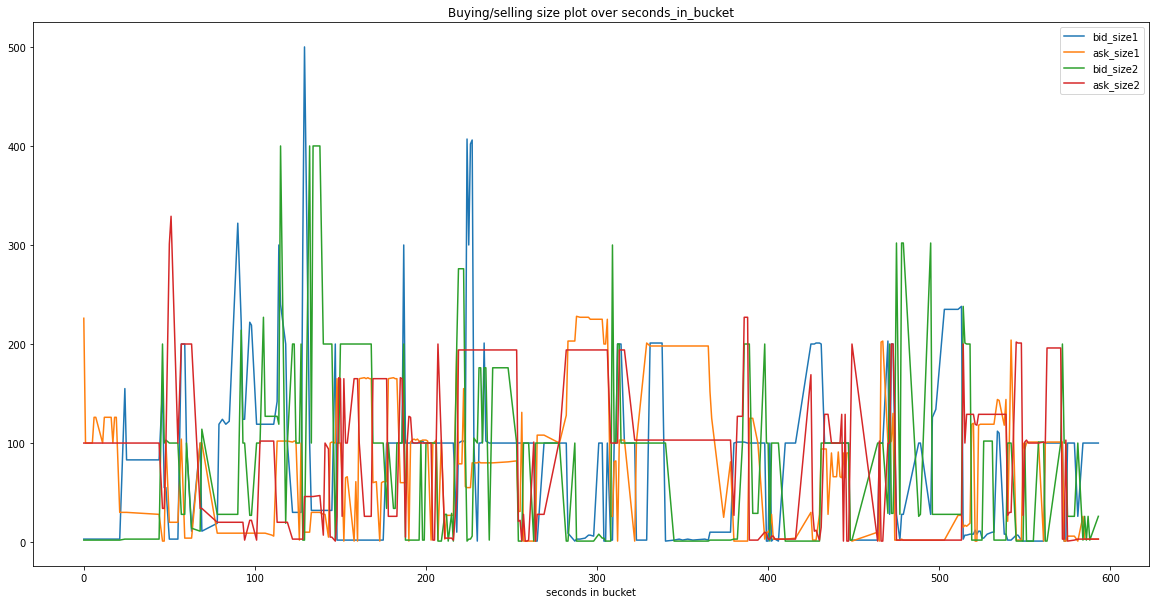

In [12]:
chunk_ob = book_sample[book_sample["time_id"]==5]                  # chun_ob means a chunk from order book


def plot_series(df, kind='price', plot_all=True, plot_wap=False):
    plt.figure(figsize=(20, 10))
    
    if plot_all:
        plt.plot(chunk_ob["seconds_in_bucket"], chunk_ob[f"bid_{kind}1"], label=f"bid_{kind}1")
        plt.plot(chunk_ob["seconds_in_bucket"], chunk_ob[f"ask_{kind}1"], label=f"ask_{kind}1")
        plt.plot(chunk_ob["seconds_in_bucket"], chunk_ob[f"bid_{kind}2"], label=f"bid_{kind}2")
        plt.plot(chunk_ob["seconds_in_bucket"], chunk_ob[f"ask_{kind}2"], label=f"ask_{kind}2")
    
    if plot_wap:
        plt.plot(chunk_ob["seconds_in_bucket"], chunk_ob[f"wap1"], label=f"wap1")
        plt.plot(chunk_ob["seconds_in_bucket"], chunk_ob[f"wap2"], label=f"wap2")
        
    plt.xlabel("seconds in bucket")
    plt.title(f"Buying/selling {kind} plot over seconds_in_bucket")
    plt.legend()
    pass

plot_series(chunk_ob)
plot_series(chunk_ob, kind="size")

Well, `ask_price2` and `bid_price1` seem to leading thier counterparts. Read that again.

For order size, nothing is interpretable from this graph for me. We will look into that later. As of now, the takeaway can be: there is no point in feeding all the buying/selling prices data for a (stock_id, time_id) pair. Cause it's redudant. What could be the relation with weighted average pricing? Let's see.

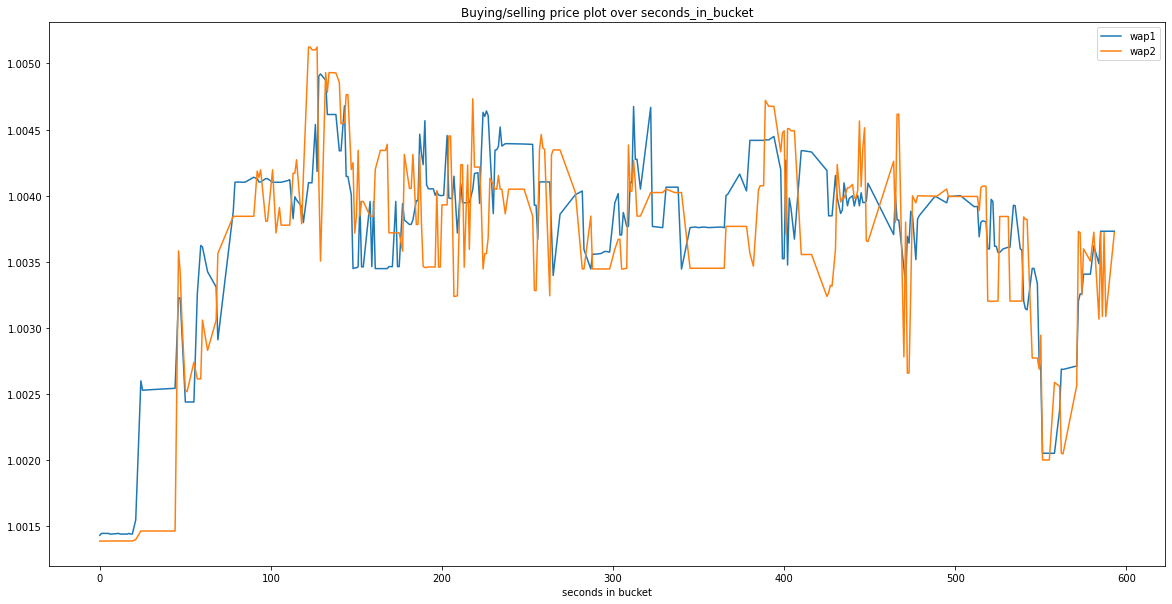

In [13]:
# utilities for realized volatility calculation
# ref: https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data/
def calculate_wap(df, rank="1"):
    df[f"wap{rank}"] = (df[f"bid_price{rank}"] * df[f"ask_size{rank}"] + df[f"ask_price{rank}"] * df[f"bid_size{rank}"])/(df[f"bid_size{rank}"] + df[f"ask_size{rank}"])
    return df
    pass

def calculate_logReturn(df, rank="1"):
    df.loc[:, f"log_return{rank}"] = np.log(df[f"wap{rank}"]).diff()
    return df[~df[f"log_return{rank}"].isnull()]
    pass

def calculate_volatility(logReturn):
    return np.sqrt(np.sum(logReturn**2))
    pass

# calculate wap1
calculate_wap(chunk_ob)
calculate_logReturn(chunk_ob)

# calculate wap2
calculate_wap(chunk_ob, rank="2")
calculate_logReturn(chunk_ob, rank="2")

plot_series(chunk_ob, plot_all=False, plot_wap=True)

In [14]:
print("True target label for stock_id==0 and time_id==5: ", train[(train["stock_id"]==0) & (train["time_id"]==5)]["target"].values[0])
print("Rank-1 target label for stock_id==0 and time_id==5: ", calculate_volatility(chunk_ob["log_return1"]))
print("Rank-2 target label for stock_id==0 and time_id==5: ", calculate_volatility(chunk_ob["log_return2"]))
print("Avg of target label for stock_id==0 and time_id==5: ", (calculate_volatility(chunk_ob["log_return1"]) + calculate_volatility(chunk_ob["log_return2"]))/2)

True target label for stock_id==0 and time_id==5:  0.004135767
Rank-1 target label for stock_id==0 and time_id==5:  0.004499364172786559
Rank-2 target label for stock_id==0 and time_id==5:  0.006998503700922706
Avg of target label for stock_id==0 and time_id==5:  0.005748933936854632


Okay, now let's inspect trade data for the same `time_id`.

In [15]:
chunk_trade = trade_sample[trade_sample["time_id"]==5]
chunk_trade.head()

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


So, what we need to find here is, how price is influenced by order_count and size. And the dependency of seconds_in_bucket. Keeping this simple, and considering the statistical features only, we can proceed for modeling.

# Feature Engineering and Dataset

Alright, we got a basic idea of what and how of the problem statement. Let's get on to it. There are actually pretty good baselines, so instead of describing more feature-centric approaches, I will build a XGB pipeline here. Let's go.

In [16]:
# feature utils
def calculate_wap(df, rank="1"):
    """
    Weighted Average Pricing for a stock at a given time ID is given by:
    (bid_price1 * ask_size1 + bid_size1 * ask_price1)/(bid_size1 + ask_size1)

    It can further be extended to:

        sum(bid_price_i * ask_size_i + bid_size_i * ask_price_i)/sum(bid_size_i + ask_size_i)

    :param rank: which wap to calculate
    :param df: parquet table containing order book
    :return:
    """
    return (df[f"bid_price{rank}"] * df[f"ask_size{rank}"] + df[f"bid_size{rank}"] * df[f"ask_price{rank}"]) / (df[f"bid_size{rank}"] + df[f"ask_size{rank}"])


def calculate_logreturn(series):
    return np.log(series).diff()


def calculate_rv(series):
    return np.sqrt(np.sum(np.square(series)))


def count_unique(series):
    return len(np.unique(series))


def get_stats_window(df, seconds_in_bucket, features_dict, add_suffix=False):
    df_feature = df[df["seconds_in_bucket"] >= seconds_in_bucket].groupby(["time_id"]).agg(features_dict).reset_index()
    df_feature.columns = ["_".join(col) for col in df_feature.columns]
    
    if add_suffix:
        df_feature = df_feature.add_suffix("_" + str(seconds_in_bucket))
        
    return df_feature
    pass

In [17]:
# configs
class cfg:
    
    paths = {
        # train path
        "train_csv": "../input/optiver-realized-volatility-prediction/train.csv",
        "train_book": "../input/optiver-realized-volatility-prediction/book_train.parquet",
        "train_trade": "../input/optiver-realized-volatility-prediction/trade_train.parquet",

        # test path
        "test_csv": "../input/optiver-realized-volatility-prediction/test.csv",
        "test_book": "../input/optiver-realized-volatility-prediction/book_test.parquet",
        "test_trade": "../input/optiver-realized-volatility-prediction/trade_test.parquet",
    }

    feature_dict_book = {
        "wap1": [np.sum, np.mean, np.std],
        "wap2": [np.sum, np.mean, np.std],
        "log_return1": [np.sum, calculate_rv, np.mean, np.std],
        "log_return2": [np.sum, calculate_rv, np.mean, np.std],
        "wap_balance": [np.sum, np.mean, np.std],
        "volume_imbalance": [np.sum, np.mean, np.std],
        "total_volume": [np.sum, np.mean, np.std],
        "price_spread1": [np.sum, np.mean, np.std],
        "price_spread2": [np.sum, np.mean, np.std],
        "bid_spread": [np.sum, np.mean, np.std],
        "ask_spread": [np.sum, np.mean, np.std],
    }

    feature_dict_trade = {
        "log_return": [calculate_rv],
        "seconds_in_bucket": [np.mean, count_unique],
        "size": [np.sum, np.mean],
        "order_count": [np.mean, np.sum],
        "agg_amount": [np.mean, np.sum, np.std]
    }
    
    model_params = {
        "xgb_bl": {
            "objective": "reg:squarederror",
            "booster": "gbtree",
            "nthread": -1,
            "eta": 0.3,
            "subsample": 0.2,
            "colsample_bytree": 0.33,
            "sampling_method": "uniform",
#             "tree_method": "gpu_hist"  # turn it on for GPU
        }
    }

In [18]:
# order book features
def get_book_features(file_path):
    book_df = pd.read_parquet(file_path)

    # calculate wap
    book_df['wap1'] = calculate_wap(book_df, rank="1")
    book_df['wap2'] = calculate_wap(book_df, rank="2")

    # calculate log return
    book_df["log_return1"] = book_df.groupby(["time_id"])["wap1"].apply(calculate_logreturn)
    book_df["log_return2"] = book_df.groupby(["time_id"])["wap2"].apply(calculate_logreturn)

    # calculate balance
    book_df["wap_balance"] = abs(book_df["wap1"] - book_df["wap2"])
    book_df["volume_imbalance"] = abs(
        (book_df["ask_size1"] + book_df["ask_size2"]) - (book_df["bid_size1"] + book_df["bid_size2"]))
    book_df["total_volume"] = book_df["ask_size1"] + book_df["ask_size2"] + book_df["bid_size1"] + book_df[
        "bid_size2"]

    # calculate spread
    book_df["price_spread1"] = (book_df["ask_price1"] - book_df["bid_price1"]) / (
            (book_df["ask_price1"] + book_df["bid_price1"]) / 2)
    book_df["price_spread2"] = (book_df["ask_price2"] - book_df["bid_price2"]) / (
            (book_df["ask_price2"] + book_df["bid_price2"]) / 2)

    book_df["bid_spread"] = book_df["bid_price1"] - book_df["bid_price2"]
    book_df["ask_spread"] = book_df["ask_price1"] - book_df["ask_price2"]

    book_df_merged = get_stats_window(book_df, seconds_in_bucket=0, features_dict=cfg.feature_dict_book)

    book_df_450 = get_stats_window(book_df, seconds_in_bucket=450, features_dict=cfg.feature_dict_book, add_suffix=True)
    book_df_300 = get_stats_window(book_df, seconds_in_bucket=300, features_dict=cfg.feature_dict_book, add_suffix=True)
    book_df_150 = get_stats_window(book_df, seconds_in_bucket=150, features_dict=cfg.feature_dict_book, add_suffix=True)

    # merge stats
    book_df_merged = book_df_merged.merge(book_df_450, how="left", left_on="time_id_", right_on="time_id__450")
    book_df_merged = book_df_merged.merge(book_df_300, how="left", left_on="time_id_", right_on="time_id__300")
    book_df_merged = book_df_merged.merge(book_df_150, how="left", left_on="time_id_", right_on="time_id__150")


    book_df_merged.drop(columns=["time_id__450", "time_id__300", "time_id__150"], inplace=True)

    book_df_merged["row_id"] = book_df_merged["time_id_"].apply(lambda x: f"{file_path.split('=')[1]}-{x}")
    book_df_merged.drop(["time_id_"], axis=1, inplace=True)

    return book_df_merged

# trade features
def get_trade_features(file_path):
    trade_df = pd.read_parquet(file_path)
    
    trade_df["log_return"] = trade_df.groupby(["time_id"])["price"].apply(calculate_logreturn)
    trade_df["agg_amount"] = trade_df["price"] * trade_df["size"]/trade_df["order_count"]

    trade_df_merged = get_stats_window(trade_df, seconds_in_bucket=0, features_dict=cfg.feature_dict_trade)

    trade_df_450 = get_stats_window(trade_df, seconds_in_bucket=450, features_dict=cfg.feature_dict_trade, add_suffix=True)
    trade_df_300 = get_stats_window(trade_df, seconds_in_bucket=300, features_dict=cfg.feature_dict_trade, add_suffix=True)
    trade_df_150 = get_stats_window(trade_df, seconds_in_bucket=150, features_dict=cfg.feature_dict_trade, add_suffix=True)

    # merge stats
    trade_df_merged = trade_df_merged.merge(trade_df_450, how="left", left_on="time_id_", right_on="time_id__450")
    trade_df_merged = trade_df_merged.merge(trade_df_300, how="left", left_on="time_id_", right_on="time_id__300")
    trade_df_merged = trade_df_merged.merge(trade_df_150, how="left", left_on="time_id_", right_on="time_id__150")
    
    trade_df_merged.drop(columns=["time_id__450", "time_id__300", "time_id__150"], inplace=True)
    
    trade_df_merged = trade_df_merged.add_prefix("trade_")

    trade_df_merged["row_id"] = trade_df_merged["trade_time_id_"].apply(lambda x: f"{file_path.split('=')[1]}-{x}")
    trade_df_merged.drop(["trade_time_id_"], axis=1, inplace=True)

    return trade_df_merged

In [19]:
class GetData:
    def __init__(self, df, book_path, trade_path):
        self.df = df.copy(deep=True)
        self.order_book_path = book_path
        self.trade_path = trade_path

        self._get_rowid()

    def _get_rowid(self):
        self.df["row_id"] = self.df["stock_id"].astype(str) + "-" + self.df["time_id"].astype(str)

    def get_time_stock(self):
        vol_cols = ['log_return1_calculate_rv', 'log_return2_calculate_rv',
                    'log_return1_calculate_rv_450', 'log_return2_calculate_rv_450',
                    'log_return1_calculate_rv_300', 'log_return2_calculate_rv_300',
                    'log_return1_calculate_rv_150', 'log_return2_calculate_rv_150',
                    'trade_log_return_calculate_rv', 'trade_log_return_calculate_rv_450',
                    'trade_log_return_calculate_rv_300', 'trade_log_return_calculate_rv_150']

        df_stock_id = self.df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min']).reset_index()
        df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
        df_stock_id = df_stock_id.add_suffix('_' + 'stock')

        df_time_id = self.df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min']).reset_index()
        df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
        df_time_id = df_time_id.add_suffix('_' + 'time')

        # Merge with original dataframe
        self.df = self.df.merge(df_stock_id, how='left', left_on=['stock_id'], right_on=['stock_id__stock'])
        self.df = self.df.merge(df_time_id, how='left', left_on=['time_id'], right_on=['time_id__time'])
        self.df.drop(['stock_id__stock', 'time_id__time'], axis=1, inplace=True)
        return self.df

    def process_features(self, list_stock_ids):
        def parallel_helper(stock_id):
            book_sample_path = os.path.join(self.order_book_path, f"stock_id={stock_id}")
            trade_sample_path = os.path.join(self.trade_path, f"stock_id={stock_id}")

            return pd.merge(get_book_features(book_sample_path), get_trade_features(trade_sample_path),
                            on="row_id",
                            how="left")

        df = Parallel(n_jobs=-1, verbose=1)(delayed(parallel_helper)(stock_id) for stock_id in list_stock_ids)
        df = pd.concat(df, ignore_index=True)

        return df

    def get_features(self):
        features_df = self.process_features(self.df["stock_id"].unique())
        self.df = self.df.merge(features_df, on=["row_id"], how="left")

        return self.get_time_stock()
        pass

In [20]:
train_data = GetData(train, cfg.paths["train_book"], cfg.paths["train_trade"])
train_df = train_data.get_features()
train_df.head()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 17.7min finished


,stock_id,time_id,target,row_id,wap1_sum,wap1_mean,wap1_std,wap2_sum,wap2_mean,wap2_std,...,trade_log_return_calculate_rv_450_max_time,trade_log_return_calculate_rv_450_min_time,trade_log_return_calculate_rv_300_mean_time,trade_log_return_calculate_rv_300_std_time,trade_log_return_calculate_rv_300_max_time,trade_log_return_calculate_rv_300_min_time,trade_log_return_calculate_rv_150_mean_time,trade_log_return_calculate_rv_150_std_time,trade_log_return_calculate_rv_150_max_time,trade_log_return_calculate_rv_150_min_time
0,0,5,0.004136,0-5,303.125061,1.003725,0.000693,303.105530,1.003661,0.000781,...,0.003242,0.000543,0.001820,0.000692,0.004595,0.000710,0.002286,0.000836,0.005362,0.000888
1,0,11,0.001445,0-11,200.047775,1.000239,0.000262,200.041168,1.000206,0.000272,...,0.002701,0.000000,0.000906,0.000460,0.002783,0.000000,0.001140,0.000583,0.002851,0.000000
2,0,16,0.002168,0-16,187.913849,0.999542,0.000864,187.939819,0.999680,0.000862,...,0.002751,0.000114,0.001100,0.000428,0.003082,0.000497,0.001347,0.000484,0.003414,0.000717
3,0,31,0.002195,0-31,119.859779,0.998832,0.000757,119.835945,0.998633,0.000656,...,0.003404,0.000000,0.001052,0.000600,0.004218,0.000000,0.001349,0.000698,0.004974,0.000269
4,0,62,0.001747,0-62,175.932861,0.999619,0.000258,175.934250,0.999626,0.000317,...,0.001936,0.000158,0.000812,0.000372,0.002470,0.000278,0.001036,0.000466,0.003281,0.000317


# Modeling

In [21]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, xgb_dtrain):
    y_true = xgb_dtrain.get_label()
    return "RMSPE", rmspe(y_true, y_pred)

class TrainFer:
    def __init__(self, params_dict, n_splits, model_path, random_state=2021):
        self.params = params_dict
        self.n_splits = n_splits
        self.random_state = random_state
        self.model_path = model_path
        
        if not os.path.isdir(model_path):
            os.makedirs(model_path)
    
    def train(self, X, y):
        oof_predictions = np.zeros(X.shape[0])
        kfold = KFold(n_splits=self.n_splits, random_state=self.random_state, shuffle=True)
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
            print(f"\nFold - {fold}\n")

            x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
            
            x_train["stock_id"] = x_train["stock_id"].astype(int)
            x_val["stock_id"] = x_val["stock_id"].astype(int)

            dtrain = xgb.DMatrix(x_train, label=y_train, weight=1/np.square(y_train), enable_categorical=True)
            dval = xgb.DMatrix(x_val, label=y_val, weight=1/np.square(y_val), enable_categorical=True)

            model = xgb.train(self.params,
                              dtrain=dtrain,
                              num_boost_round=10000,
                              evals=[(dtrain, "dtrain"), (dval, "dval")],
                              verbose_eval=50,
                              feval=feval_rmspe,
                              early_stopping_rounds=200)
            
            pickle.dump(model, open(os.path.join(self.model_path, f"xgb_bl_{fold}.pkl"), "wb"))
            oof_predictions[val_idx] = model.predict(dval)
            
        rmspe_score = rmspe(y, oof_predictions)
        print(f"OOF RMSPE: {rmspe_score}")

In [22]:
trainer = TrainFer(cfg.model_params["xgb_bl"], n_splits=5, model_path="./xgbBaseline/")
trainer.train(train_df.drop(columns=["row_id", "target", "time_id"]), train_df["target"])


Fold - 0

[0]	dtrain-rmse:0.34874	dtrain-RMSPE:161.28665	dval-rmse:0.34875	dval-RMSPE:161.86838
[50]	dtrain-rmse:0.00048	dtrain-RMSPE:0.22106	dval-rmse:0.00051	dval-RMSPE:0.23702
[100]	dtrain-rmse:0.00047	dtrain-RMSPE:0.21599	dval-rmse:0.00052	dval-RMSPE:0.23939
[150]	dtrain-rmse:0.00046	dtrain-RMSPE:0.21384	dval-rmse:0.00052	dval-RMSPE:0.24060
[200]	dtrain-rmse:0.00046	dtrain-RMSPE:0.21052	dval-rmse:0.00052	dval-RMSPE:0.24331
[250]	dtrain-rmse:0.00045	dtrain-RMSPE:0.20932	dval-rmse:0.00054	dval-RMSPE:0.25168
[274]	dtrain-rmse:0.00045	dtrain-RMSPE:0.20781	dval-rmse:0.00053	dval-RMSPE:0.24485

Fold - 1

[0]	dtrain-rmse:0.34875	dtrain-RMSPE:161.57075	dval-rmse:0.34873	dval-RMSPE:160.73322
[50]	dtrain-rmse:0.00047	dtrain-RMSPE:0.21969	dval-rmse:0.00049	dval-RMSPE:0.22622
[100]	dtrain-rmse:0.00047	dtrain-RMSPE:0.21588	dval-rmse:0.00050	dval-RMSPE:0.23166
[150]	dtrain-rmse:0.00046	dtrain-RMSPE:0.21421	dval-rmse:0.00051	dval-RMSPE:0.23340
[200]	dtrain-rmse:0.00046	dtrain-RMSPE:0.21185	dval-

### Work In Progress